## Shorten the names of superoperator files

In [18]:
import os
import shutil

folder = r'C:\Users\ssingh8\OneDrive - Delft University of Technology\Research\[PROJECTS]\Emission based direct schemes\simulations_data\1_basic_first_simulation\0_first_rates_at_inf_cutoff\New folder'

def copy_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith("merged.csv"):
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, "copy_" + filename)
            shutil.copy2(source, destination)

# for EM Direct WT4
def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.startswith("copy_"):
            bell_type = filename[filename.find("bell_pair_type-")+len("bell_pair_type-"):filename.rfind("_network_")]
            nn_type =  filename[filename.find("network_noise_type-")+len("network_noise_type-"):filename.rfind("_p_g")]
            set_parameters = filename[filename.find("hc_direct_ghz_node-")+len("hc_direct_ghz_node-"):filename.rfind("_bell_pair_type")]
            pg_val = float(filename[filename.find("p_g-")+len("p_g-"):filename.rfind("_p_m")])
            new_filename = filename.replace(filename, f"copy_{set_parameters}_bell_{bell_type}_nntype_{nn_type}_p_g-{pg_val}_p_m_.csv")
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, new_filename)
            os.rename(source, destination)


copy_files(folder)
rename_files(folder)

# Threshold data for direct emission scheme

Reduced chi squared is 2533.274371033828.
Least squared fitting on dataset results:
Threshold = 0.004513854076580802 +- 0.00039986980138172434
A= 0.9289872131757907 B= -16.596784566993772 C= 73.57059984291763
D= -1.9800000000000004 nu= 1.199989783802793 mu= 0.71

Reduced chi-squared for fit equals 2533.274371033828.
0.00039986980138172434
The LSR at threshold (pth): 0.9289872131757907 +- 0.05263418772823669


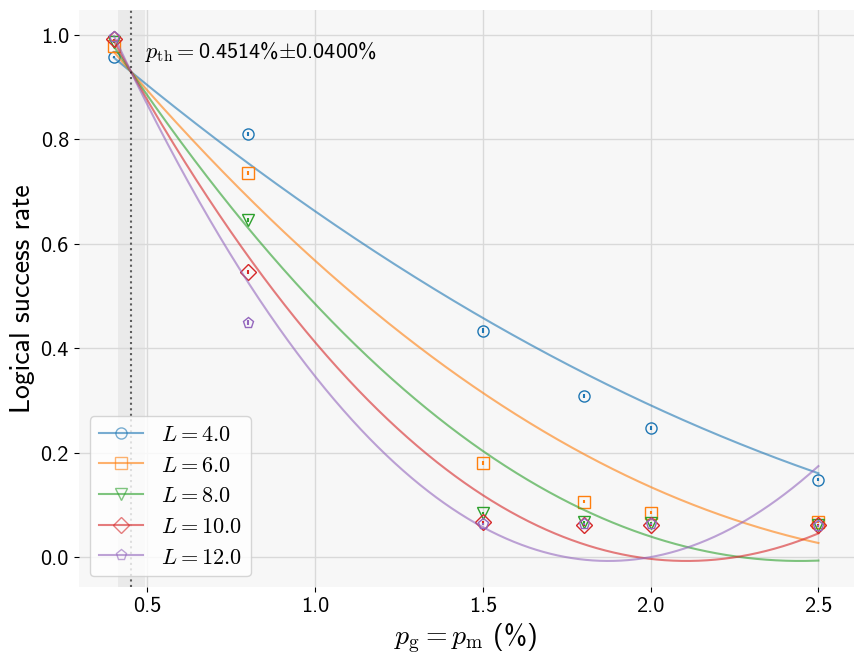

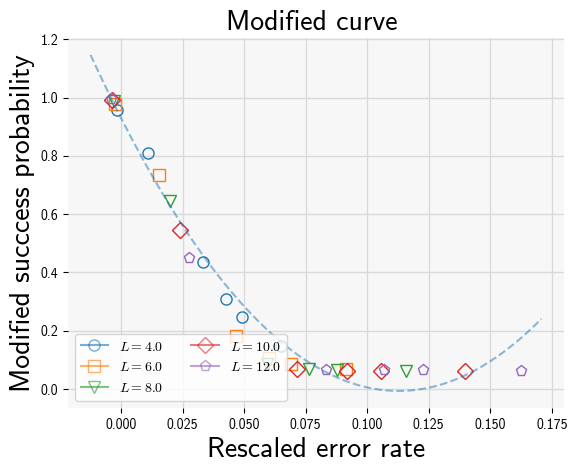

(<Figure size 1000x750 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

In [22]:
import pandas as pd
from oopsc.threshold.plot import plot_thresholds
# import seaborn as sns


### DATA FOR THE THRESHOLDS FOR DIFFERENT CASES ###

# RAW FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.14674],"1":[0.0001,0.14974],"2":[0.0005,0.14266],"3":[0.0008,0.13734],"4":[0.001,0.13724],"5":[0.002,0.12682],"6":[0.003,0.11836],"7":[0.004,0.11064]},"(6, 6)":{"0":[0.00001,0.07312],"1":[0.0001,0.0724],"2":[0.0005,0.07142],"3":[0.0008,0.06996],"4":[0.001,0.06756],"5":[0.002,0.06716],"6":[0.003,0.06568],"7":[0.004,0.06592]},"(8, 8)":{"0":[0.00001,0.06322],"1":[0.0001,0.06414],"2":[0.0005,0.0627],"3":[0.0008,0.0632],"4":[0.001,0.06374],"5":[0.002,0.06412],"6":[0.003,0.06404],"7":[0.004,0.06252]},"(10, 10)":{"0":[0.00001,0.06482],"1":[0.0001,0.0612],"2":[0.0005,0.06292],"3":[0.0008,0.0618],"4":[0.001,0.0615],"5":[0.002,0.0628],"6":[0.003,0.06246],"7":[0.004,0.06272]},"(12, 12)":{"0":[0.00001,0.06306],"1":[0.0001,0.06206],"2":[0.0005,0.06212],"3":[0.0008,0.06266],"4":[0.001,0.06216],"5":[0.002,0.06184],"6":[0.003,0.06158],"7":[0.004,0.06222]}}

# BASIC FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.9998],"1":[0.0001,0.99982],"2":[0.0005,0.9993],"3":[0.0008,0.99806],"4":[0.001,0.99732],"5":[0.002,0.99064],"6":[0.003,0.97748],"7":[0.004,0.95886]},"(6, 6)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,0.99976],"4":[0.001,0.99974],"5":[0.002,0.99804],"6":[0.003,0.9921],"7":[0.004,0.97586]},"(8, 8)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,0.99994],"5":[0.002,0.99948],"6":[0.003,0.99726],"7":[0.004,0.9865]},"(10, 10)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99992],"6":[0.003,0.99878],"7":[0.004,0.99184]},"(12, 12)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99996],"6":[0.003,0.99958],"7":[0.004,0.99578]}}
data = {"(4, 4)":{"0":[0.004,0.95792],"1":[0.008,0.80982],"2":[0.015,0.43398],"3":[0.018,0.30888],"4":[0.02,0.24822],"5":[0.025,0.14874]},"(6, 6)":{"0":[0.004,0.97788],"1":[0.008,0.7354],"2":[0.015,0.1808],"3":[0.018,0.10596],"4":[0.02,0.08518],"5":[0.025,0.06764]},"(8, 8)":{"0":[0.004,0.98632],"1":[0.008,0.64612],"2":[0.015,0.08508],"3":[0.018,0.06686],"4":[0.02,0.06604],"5":[0.025,0.0619]},"(10, 10)":{"0":[0.004,0.9917],"1":[0.008,0.5464],"2":[0.015,0.06674],"3":[0.018,0.06224],"4":[0.02,0.06272],"5":[0.025,0.061]},"(12, 12)":{"0":[0.004,0.99568],"1":[0.008,0.44886],"2":[0.015,0.06368],"3":[0.018,0.06378],"4":[0.02,0.06434],"5":[0.025,0.06028]}}
# data = {"(4, 4)":{"1":[0.001,0.99744],"2":[0.002,0.98984],"3":[0.003,0.9784],"4":[0.004,0.95926],"5":[0.008,0.8081]},"(6, 6)":{"1":[0.001,0.99978],"2":[0.002,0.99814],"3":[0.003,0.99278],"4":[0.004,0.97702],"5":[0.008,0.73422]},"(8, 8)":{"1":[0.001,0.99996],"2":[0.002,0.99962],"3":[0.003,0.99716],"4":[0.004,0.98624],"5":[0.008,0.648]},"(10, 10)":{"1":[0.001,1.0],"2":[0.002,1.0],"3":[0.003,0.99888],"4":[0.004,0.99244],"5":[0.008,0.54708]},"(12, 12)":{"1":[0.001,1.0],"2":[0.002,0.99998],"3":[0.003,0.99956],"4":[0.004,0.99526],"5":[0.008,0.44674]}}

# MEDIUM FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = 


iters = 50000

rates = [rate[0] for rate in list(data["(6, 6)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]

data_frame = pd.DataFrame(columns=["L", "p_g", "N", "success"])

for p_rate, success in zip(rates, l4):
    to_add = [4, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l6):
    to_add = [6, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l8):
    to_add = [8, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l10):
    to_add = [10, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l12):
    to_add = [12, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add


data_frame = data_frame.set_index(["L", "p_g"])
# sns.set(style="darkgrid")
plot_thresholds(data=data_frame,output="example_threshold", modified_ansatz=False, accuracy=None)

# Cirq code for basic protocol

In [2]:
import cirq
import numpy as np

# Helper function to create a random density matrix for n qubits
def random_density_matrix(num_qubits):
    dim = 2**num_qubits
    random_state = np.random.rand(dim, dim) + 1j * np.random.rand(dim, dim)  # Random complex matrix
    random_state = random_state @ random_state.conj().T  # Make it Hermitian and positive semi-definite
    random_state /= np.trace(random_state)  # Normalize to make it a density matrix
    return random_state

t_link = 1e-6
p_link_raw = 0.001
T1n_idle = 10
T2n_idle = 10
T1e_idle = 10
T2e_idle = 10
T1n_link = 10
T2n_link = 10
t_CX = 0.001

density_matrix_1 = random_density_matrix(4)  # First 4-qubit density matrix
density_matrix_2 = random_density_matrix(4)  # Second 4-qubit density matrix

qubits_1 = [cirq.LineQubit(i) for i in range(4)]  # Qubits for density matrix 1
qubits_2 = [cirq.LineQubit(i + 4) for i in range(4)]  # Qubits for density matrix 2

simulator = cirq.DensityMatrixSimulator()
combined_density_matrix = np.kron(density_matrix_1, density_matrix_2)

gad_channel = cirq.generalized_amplitude_damp(0.5, 1-)

operations = [cirq.CNOT(qubits_1[i], qubits_2[i]) for i in range(4)] # All these CNOT gates are parallel on the architecture

circuit = cirq.Circuit(operations)
result = simulator.simulate(circuit, initial_state=combined_density_matrix)
final_density_matrix = result.final_density_matrix

# Post-select the second set of qubits (qubits_2) in |0><0| state, this is the detection pattern for the memory qubit measurement
# Define the projector for |0><0| on a single qubit
projector = np.array([[1, 0], [0, 0]])

# Create the full projection operator for the second set of qubits (qubits_2)
post_selection_operator = np.kron(np.eye(2**4), np.kron(projector, np.kron(projector, np.kron(projector, projector))))

# Apply the projection to the final density matrix
post_selected_matrix = post_selection_operator @ final_density_matrix @ post_selection_operator.T

# Renormalize the density matrix (ensure trace = 1)
trace = np.trace(post_selected_matrix)
if trace != 0:
    post_selected_matrix /= trace

# Print the random density matrices, the final matrix, and the post-selected density matrix
print("Initial Random Density Matrix 1:")
print(density_matrix_1)

print("\nInitial Random Density Matrix 2:")
print(density_matrix_2)

print("\nFinal Density Matrix after CNOT Gates:")
print(final_density_matrix)

print("\nPost-selected Density Matrix:")
print(post_selected_matrix)

Initial Random Density Matrix 1:
[[0.06207789+0.j         0.04518409-0.00125343j 0.05283963+0.0199035j
  0.04137071+0.00441461j 0.05567717+0.00598337j 0.0357811 +0.01340305j
  0.04630663-0.00440509j 0.05228368+0.00365183j 0.05282922+0.0112768j
  0.04568051+0.01281958j 0.04681368-0.00805443j 0.03062597+0.00538464j
  0.05068561-0.00399724j 0.04363884-0.00523789j 0.0472456 +0.00682235j
  0.04915698-0.00792604j]
 [0.04518409+0.00125343j 0.06993834+0.j         0.04843582+0.01874391j
  0.04236038+0.00929234j 0.05463399-0.00351685j 0.04531313+0.01153001j
  0.05087236-0.00642526j 0.05140602+0.01474423j 0.05663203+0.01799945j
  0.04831888+0.01220668j 0.04476913-0.01059419j 0.03452905+0.00582697j
  0.0528698 -0.00063691j 0.04098487-0.00579945j 0.05417398+0.00551167j
  0.05587972-0.00123546j]
 [0.05283963-0.0199035j  0.04843582-0.01874391j 0.07203846+0.j
  0.046232  -0.01684684j 0.05644317-0.02304124j 0.04692824-0.00421503j
  0.04557533-0.02173147j 0.05291445-0.00666153j 0.0556259 -0.007795j
  0.